In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt

# Load Model
from keras.models import model_from_json

# Đọc cấu trúc model từ tệp .json
with open("model/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Tải trọng số vào model đã load
loaded_model.load_weights("model/model.weights.h5")

# Compile model (cần thiết để tiếp tục sử dụng model)
loaded_model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# Load dữ liệu
image_dir = Path('D:/Huan/Learning/DL/data/UTKFace')
filepaths = pd.Series(list(image_dir.glob('*.jpg.chip.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(x)[-1].split('_')[0]), name='Age').astype(int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=100).reset_index(drop=True)
# Chia dữ liệu thành 2 phần train và test với tỉ lệ 9:1
train_df, test_df = train_test_split(images, test_size = 0.1, random_state = 0)
   

# Tạo đối tượng ImageDataGenerator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='raw',
    batch_size=256,
    shuffle=False
)

# Tính giá trị trung bình của tuổi dự đoán 
predicted_ages = np.squeeze(loaded_model.predict(test_images))
true_ages = test_images.labels
mean = [abs(np.mean([predicted_ages[i] for i in range(len(true_ages)) if true_ages[i] == j]) - j) if j in true_ages else 0 for j in range(1,117) ]



Found 2371 validated image filenames.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


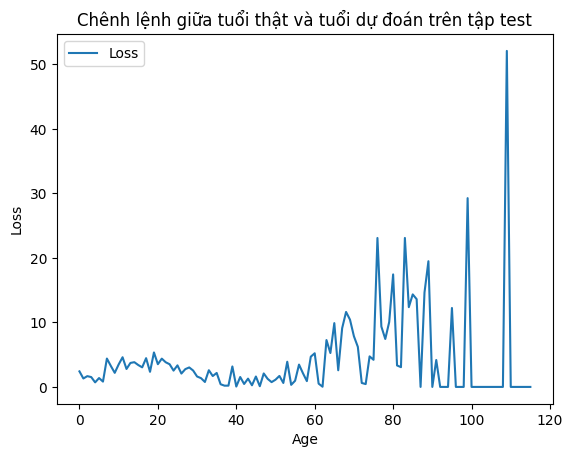

In [2]:
# Vẽ đồ thị
plt.plot(mean, label='Loss')

# Đặt tiêu đề và chú thích trục
plt.xlabel('Age')
plt.ylabel('Loss')
plt.title('Chênh lệnh giữa tuổi thật và tuổi dự đoán trên tập test')

# Thêm chú thích cho đồ thị
plt.legend()

# Hiển thị đồ thị
plt.show()